In [ ]:
# !pip install scikit-fuzzy 
# !pip install geneticalgorithm2 
# !pip install swig
# !pip install gymnasium 
# !pip install gymnasium[classic_control]

In [4]:
import gymnasium as gym
import skfuzzy as fuzz
from skfuzzy import control as ctrl
import numpy as np
import math
from geneticalgorithm2 import geneticalgorithm2 as ga

# Mountain Car

Vamos agora rodar o SIF em um problema um pouquinho mais interessante, chamado Mountain Car.

In [20]:
# Define the fuzzy controller

def create_car_controller():
    x_pos = ctrl.Antecedent(np.arange(-1, 1.01, 0.01), 'x_pos')
    velocity = ctrl.Antecedent(np.arange(-8, 8.01, 0.01), 'velocity')
    aceleration = ctrl.Consequent(np.arange(-1, 1.01, 0.01), 'aceleration')

    # Define membership functions for the input variables (position, velocity, angle, angular_velocity)
    x_pos['negative'] = fuzz.trapmf(x_pos.universe, [-1.1, -1, -0.05, 0])
    x_pos['zero'] = fuzz.trimf(x_pos.universe, [-0.05, 0, 0.05])
    x_pos['positive'] = fuzz.trapmf(x_pos.universe, [0, 0.05, 1, 1.1])

    velocity['negative'] = fuzz.trapmf(velocity.universe, [-8.1, -8.0, -1, 0])
    velocity['zero'] = fuzz.trimf(velocity.universe, [-1, 0, 1])
    velocity['positive'] = fuzz.trapmf(velocity.universe, [0, 1, 8, 8.1])

    aceleration['negative'] = fuzz.trapmf(aceleration.universe, [-1.0, -1.0, -0.8, -0.5])
    aceleration['little negative'] = fuzz.trimf(aceleration.universe, [-0.8, -0.5, 0])
    aceleration['zero'] = fuzz.trimf(aceleration.universe, [-0.5, 0, 0.5])
    aceleration['little positive'] = fuzz.trimf(aceleration.universe, [0, 0.5, 0.8])
    aceleration['positive'] = fuzz.trapmf(aceleration.universe, [0.5, 0.8, 1.0, 1.0])


    rules = [ctrl.Rule(antecedent=(x_pos['zero'] & velocity['positive']), consequent=(aceleration['positive'])),
             ctrl.Rule(antecedent=(x_pos['zero'] & velocity['negative']), consequent=(aceleration['negative'])),
             ctrl.Rule(antecedent=(x_pos['negative'] & velocity['positive']), consequent=(aceleration['positive'])),
             ctrl.Rule(antecedent=(x_pos['negative'] & velocity['zero']), consequent=(aceleration['little negative'])),
             ctrl.Rule(antecedent=(x_pos['negative'] & velocity['negative']), consequent=(aceleration['negative'])),
             ctrl.Rule(antecedent=(x_pos['positive'] & velocity['positive']), consequent=(aceleration['positive'])),
             ctrl.Rule(antecedent=(x_pos['positive'] & velocity['zero']), consequent=(aceleration['little positive'])),
             ctrl.Rule(antecedent=(x_pos['positive'] & velocity['negative']), consequent=(aceleration['negative'])),
            ]
    
    # Create the fuzzy control system for torque
    torque_ctrl = ctrl.ControlSystem(rules)

    # Create a simulation with the control system for torque
    torque_sim = ctrl.ControlSystemSimulation(torque_ctrl)

    return torque_sim


In [22]:
fuzzy_controller = create_car_controller()

import time 

env = gym.make('MountainCarContinuous-v0', render_mode='human')

state = env.reset()
obs = state[0]
total_reward = 0
done = False
episode = 1
k = 0
x_poses = []
y_poses = []
a_speeds = []
actions = []
while not done:
    # theta_value = get_theta(obs[0], obs[1])
    x_poses.append(obs[0])
    y_poses.append(obs[1])
    try:
        fuzzy_controller.input['x_pos'] = obs[0] + 0.5
        fuzzy_controller.input['velocity'] = obs[1]*100
        fuzzy_controller.compute()
        action = fuzzy_controller.output['aceleration']
    except:
        action = 0
    # action = 0
    actions.append(action)
    obs, reward, done, _, _ = env.step([action])
    total_reward += reward
    k += 1

    time.sleep(0.1)

    if k > 300:
        break

print(total_reward)
env.close()

95.33290659320042


# Pendulum

Podemos também trabalhar em um problema um pouquinho mais complexo...

In [2]:
env = gym.make('Pendulum-v1', g=9.81) #, render_mode="human")

In [ ]:
# Define the fuzzy controller

def create_controller(x):
    theta = ctrl.Antecedent(np.arange(-1, 1.01, 0.01), 'theta')
    theta = ctrl.Antecedent(np.arange(-1, 1.01, 0.01), 'theta')

    angular_velocity = ctrl.Antecedent(np.arange(-8, 8.01, 0.01), 'angular_velocity')
    torque = ctrl.Consequent(np.arange(-2, 2.01, 0.01), 'torque')

    # Define membership functions for the input variables (position, velocity, angle, angular_velocity)
    theta['negative'] = fuzz.trapmf(theta.universe, [-1.1, -1, -1 + x[0], 0])
    theta['zero'] = fuzz.trimf(theta.universe, [-1 + x[0], 0, 1 - x[1]])
    theta['positive'] = fuzz.trapmf(theta.universe, [0, 1 - x[1], 1, 1.1])

    angular_velocity['negative'] = fuzz.trapmf(angular_velocity.universe, [-8.1, -8.0, -8 + x[2], 0])
    angular_velocity['zero'] = fuzz.trimf(angular_velocity.universe, [-8 + x[2], 0, 8 - x[3]])
    angular_velocity['positive'] = fuzz.trapmf(angular_velocity.universe, [0, 8 - x[3], 8, 8.1])

    # Define membership functions for the output variables (throttle and orientation)
    torque['negative'] = fuzz.trapmf(torque.universe, [-2.1, -2, -2 + x[4], -2 + x[4] + x[5]])
    torque['little negative'] = fuzz.trimf(torque.universe, [-2 + x[4], -2 + x[4] + x[5], 0])
    torque['zero'] = fuzz.trimf(torque.universe, [-2 + x[4] + x[5], 0, x[6]])
    torque['little positive'] = fuzz.trimf(torque.universe, [0, 2 - x[7] - x[6], 2 - x[7]])
    torque['positive'] = fuzz.trapmf(torque.universe, [2 - x[7] - x[6], 2 - x[7], 2, 2.1])


    # Define fuzzy rules for torque and orientation
    rules = [ctrl.Rule(antecedent=(theta['zero']), consequent=(torque['zero'])),
             
             ctrl.Rule(antecedent=(theta['zero'] & angular_velocity['negative']), consequent=(torque['positive'])),
             ctrl.Rule(antecedent=(theta['zero'] & angular_velocity['negative']), consequent=(torque['little positive'])),
             ctrl.Rule(antecedent=(theta['zero'] & angular_velocity['negative']), consequent=(torque['zero'])),
             ctrl.Rule(antecedent=(theta['zero'] & angular_velocity['negative']), consequent=(torque['little negative'])),
             ctrl.Rule(antecedent=(theta['zero'] & angular_velocity['negative']), consequent=(torque['little negative'])),             

             ctrl.Rule(antecedent=(theta['zero'] & angular_velocity['positive']), consequent=(torque['positive'])),
             ctrl.Rule(antecedent=(theta['zero'] & angular_velocity['positive']), consequent=(torque['little positive'])),
             ctrl.Rule(antecedent=(theta['zero'] & angular_velocity['positive']), consequent=(torque['zero'])),
             ctrl.Rule(antecedent=(theta['zero'] & angular_velocity['positive']), consequent=(torque['little negative'])),
             ctrl.Rule(antecedent=(theta['zero'] & angular_velocity['positive']), consequent=(torque['little negative'])),

             ctrl.Rule(antecedent=(theta['positive']), consequent=(torque['positive'])),
             ctrl.Rule(antecedent=(theta['positive']), consequent=(torque['little positive'])),
             ctrl.Rule(antecedent=(theta['positive']), consequent=(torque['zero'])),
             ctrl.Rule(antecedent=(theta['positive']), consequent=(torque['little negative'])),
             ctrl.Rule(antecedent=(theta['positive']), consequent=(torque['little negative'])),

             ctrl.Rule(antecedent=(theta['positive'] & angular_velocity['negative']), consequent=(torque['positive'])),
             ctrl.Rule(antecedent=(theta['positive'] & angular_velocity['negative']), consequent=(torque['little positive'])),
             ctrl.Rule(antecedent=(theta['positive'] & angular_velocity['negative']), consequent=(torque['zero'])),
             ctrl.Rule(antecedent=(theta['positive'] & angular_velocity['negative']), consequent=(torque['little negative'])),
             ctrl.Rule(antecedent=(theta['positive'] & angular_velocity['negative']), consequent=(torque['little negative'])),             

             ctrl.Rule(antecedent=(theta['positive'] & angular_velocity['positive']), consequent=(torque['positive'])),
             ctrl.Rule(antecedent=(theta['positive'] & angular_velocity['positive']), consequent=(torque['little positive'])),
             ctrl.Rule(antecedent=(theta['positive'] & angular_velocity['positive']), consequent=(torque['zero'])),
             ctrl.Rule(antecedent=(theta['positive'] & angular_velocity['positive']), consequent=(torque['little negative'])),
             ctrl.Rule(antecedent=(theta['positive'] & angular_velocity['positive']), consequent=(torque['little negative'])),

             ctrl.Rule(antecedent=(theta['negative']), consequent=(torque['positive'])),
             ctrl.Rule(antecedent=(theta['negative']), consequent=(torque['little positive'])),
             ctrl.Rule(antecedent=(theta['negative']), consequent=(torque['zero'])),
             ctrl.Rule(antecedent=(theta['negative']), consequent=(torque['little negative'])),
             ctrl.Rule(antecedent=(theta['negative']), consequent=(torque['little negative'])),

             ctrl.Rule(antecedent=(theta['negative'] & angular_velocity['negative']), consequent=(torque['positive'])),
             ctrl.Rule(antecedent=(theta['negative'] & angular_velocity['negative']), consequent=(torque['little positive'])),
             ctrl.Rule(antecedent=(theta['negative'] & angular_velocity['negative']), consequent=(torque['zero'])),
             ctrl.Rule(antecedent=(theta['negative'] & angular_velocity['negative']), consequent=(torque['little negative'])),
             ctrl.Rule(antecedent=(theta['negative'] & angular_velocity['negative']), consequent=(torque['little negative'])),             

             ctrl.Rule(antecedent=(theta['negative'] & angular_velocity['positive']), consequent=(torque['positive'])),
             ctrl.Rule(antecedent=(theta['negative'] & angular_velocity['positive']), consequent=(torque['little positive'])),
             ctrl.Rule(antecedent=(theta['negative'] & angular_velocity['positive']), consequent=(torque['zero'])),
             ctrl.Rule(antecedent=(theta['negative'] & angular_velocity['positive']), consequent=(torque['little negative'])),
             ctrl.Rule(antecedent=(theta['negative'] & angular_velocity['positive']), consequent=(torque['little negative'])),
            ]
          
    # LEN(rules) = 41, so far. 
    selected_rules = [rule for rule, s in zip(rules, x[8:]) if s == 1]

    # Create the fuzzy control system for torque
    torque_ctrl = ctrl.ControlSystem(selected_rules)

    # Create a simulation with the control system for torque
    torque_sim = ctrl.ControlSystemSimulation(torque_ctrl)

    return torque_sim


In [ ]:
def get_theta(cos_theta, sin_theta):
    theta = math.atan2(sin_theta, cos_theta)
    return theta/math.pi

In [ ]:
def fitness_function(x):

    try:
        fuzzy_controller = create_controller(x)
    
        episodes = 10 
        
        # thetas = []
        # actions = []
        rewards = []
        for i in range(episodes):
            state = env.reset()
            obs = state[0]
            total_reward = 0
            done = False
            k = 0
            while not done:
                theta_value = get_theta(obs[0], obs[1])
                # thetas.append(theta_value)
                fuzzy_controller.input['theta'] = theta_value
                fuzzy_controller.input['angular_velocity'] = obs[2]
                fuzzy_controller.compute()
                action = fuzzy_controller.output['torque']
                # actions.append(action)
                obs, reward, done, _, _ = env.step([action])
                total_reward += reward
                k += 1
                if k == 100:
                    break
            rewards.append(total_reward)

        total_reward = sum(rewards)/episodes 
        #print(f"Episode {episode}: Total Reward: {total_reward}")

    except Exception as e:
        print(e)
        total_reward = -100000

    finally:
        env.close()
        return -total_reward 

    # Simulate the OpenAI Pendulum environment using the fuzzy controller.
    # Calculate a fitness score based on the performance.

# Define the bounds for the genes (x) based on their values.
varbound = np.array([[0, 0.8]] * 8 + [[0, 1]] * 41)  # Replace min_value and max_value with actual bounds.
variable_type = np.array(['real'] * 8 + ['int'] * 41)

population_size = 100
mutation_rate = 0.1
num_generations = 100

algorithm_param = {'max_num_iteration': num_generations,
                   'population_size': population_size,
                   'mutation_probability': mutation_rate,
                   'elit_ratio': 0.01,
                   'crossover_probability': 0.5,
                   'crossover_type': 'uniform',
                   'max_iteration_without_improv': None}

model = ga(function=fitness_function, dimension=49, variable_type=variable_type, variable_boundaries=varbound, algorithm_parameters=algorithm_param)

# Run the genetic algorithm optimization.
model.run()


In [ ]:
x = model.result.variable

fuzzy_controller = create_controller(x)

state = env.reset()
obs = state[0]
total_reward = 0
done = False
episode = 1
k = 0
#env.render()
thetas = []
actions = []
while not done:
    theta_value = get_theta(obs[0], obs[1])
    thetas.append(theta_value)
    fuzzy_controller.input['theta'] = theta_value
    fuzzy_controller.input['angular_velocity'] = obs[2]
    fuzzy_controller.compute()
    action = fuzzy_controller.output['torque']
    actions.append(action)
    obs, reward, done, _, _ = env.step([action])
    total_reward += reward
    k += 1
    if k == 100:
        break

print(total_reward)

In [ ]:
import matplotlib.pyplot as plt
# x = model.result.variable
env = gym.make('Pendulum-v1', g=9.81, render_mode="human")
# fuzzy_controller = create_controller(x)

state = env.reset()
obs = state[0]
total_reward = 0
done = False
episode = 1
k = 0
env.render()
thetas = []
actions = []
while not done:
    theta_value = get_theta(obs[0], obs[1])
    thetas.append(theta_value)
    # fuzzy_controller.input['theta'] = theta_value
    # fuzzy_controller.input['angular_velocity'] = obs[2]
    # fuzzy_controller.compute()
    # action = fuzzy_controller.output['torque']
    action = 5
    actions.append(action)
    obs, reward, done, _, _ = env.step([action])
    total_reward += reward
    k += 1
    if k == 100:
        break
env.close()
print(total_reward)

plt.plot(thetas)
#plt.plot(actions)

In [2]:
# Define the fuzzy controller

env = gym.make('Pendulum-v1', g=9.81, render_mode="human")

def create_controller(x):
    x_pos = ctrl.Antecedent(np.arange(-1, 1.01, 0.01), 'x_pos')
    y_pos = ctrl.Antecedent(np.arange(-1, 1.01, 0.01), 'y_pos')
    angular_velocity = ctrl.Antecedent(np.arange(-8, 8.01, 0.01), 'angular_velocity')
    torque = ctrl.Consequent(np.arange(-2, 2.01, 0.01), 'torque')

    # Define membership functions for the input variables (position, velocity, angle, angular_velocity)
    x_pos['negative'] = fuzz.trapmf(x_pos.universe, [-1.1, -1, -0.3, 0])
    x_pos['zero'] = fuzz.trimf(x_pos.universe, [-0.3, 0, 0.3])
    x_pos['positive'] = fuzz.trapmf(x_pos.universe, [0, 0.3, 1, 1.1])

    y_pos['negative'] = fuzz.trapmf(y_pos.universe, [-1.1, -1, -0.2, 0])
    y_pos['zero'] = fuzz.trimf(y_pos.universe, [-0.2, 0, 0.2])
    y_pos['positive'] = fuzz.trapmf(y_pos.universe, [0, 0.2, 1, 1.1])

    angular_velocity['negative'] = fuzz.trapmf(angular_velocity.universe, [-8.1, -8.0, -1, 0])
    angular_velocity['zero'] = fuzz.trimf(angular_velocity.universe, [-1, 0, 1])
    angular_velocity['positive'] = fuzz.trapmf(angular_velocity.universe, [0, 1, 8, 8.1])

    # Define membership functions for the output variables (throttle and orientation)
    torque['negative'] = fuzz.trapmf(torque.universe, [-1.5, -1.4, -1, -0.5])
    torque['little negative'] = fuzz.trimf(torque.universe, [-1, -0.5, 0])
    torque['zero'] = fuzz.trimf(torque.universe, [-0.5, 0, 0.5])
    torque['little positive'] = fuzz.trimf(torque.universe, [0, 0.5, 1])
    torque['positive'] = fuzz.trapmf(torque.universe, [0.5, 1, 1.4, 1.5])


    # Define fuzzy rules for torque and orientation
    rules = [ctrl.Rule(antecedent=(y_pos['zero'] & x_pos['positive']), consequent=(torque['zero'])),
             
             ctrl.Rule(antecedent=(y_pos['zero'] & x_pos['positive'] & angular_velocity['negative']), consequent=(torque['little positive'])),
             ctrl.Rule(antecedent=(y_pos['zero'] & x_pos['positive'] & angular_velocity['positive']), consequent=(torque['little negative'])),
            #  ctrl.Rule(antecedent=(y_pos['positive'] & x_pos['positive']), consequent=(torque['positive'])),
            #  ctrl.Rule(antecedent=(y_pos['negative'] & x_pos['positive']), consequent=(torque['negative'])),

             ctrl.Rule(antecedent=(y_pos['zero']), consequent=(torque['zero'])),

            # Quarto quadrante

             ctrl.Rule(antecedent=(y_pos['negative'] & x_pos['negative'] & angular_velocity['negative']), consequent=(torque['positive'])),
             ctrl.Rule(antecedent=(y_pos['negative'] & x_pos['negative'] & angular_velocity['negative']), consequent=(torque['little positive'])),
             ctrl.Rule(antecedent=(y_pos['negative'] & x_pos['negative'] & angular_velocity['negative']), consequent=(torque['zero'])),
             ctrl.Rule(antecedent=(y_pos['negative'] & x_pos['negative'] & angular_velocity['negative']), consequent=(torque['little negative'])),
             ctrl.Rule(antecedent=(y_pos['negative'] & x_pos['negative'] & angular_velocity['negative']), consequent=(torque['negative'])),             

             ctrl.Rule(antecedent=(y_pos['negative'] & x_pos['negative'] & angular_velocity['zero']), consequent=(torque['positive'])),
             ctrl.Rule(antecedent=(y_pos['negative'] & x_pos['negative'] & angular_velocity['zero']), consequent=(torque['little positive'])),
             ctrl.Rule(antecedent=(y_pos['negative'] & x_pos['negative'] & angular_velocity['zero']), consequent=(torque['zero'])),
             ctrl.Rule(antecedent=(y_pos['negative'] & x_pos['negative'] & angular_velocity['zero']), consequent=(torque['little negative'])),
             ctrl.Rule(antecedent=(y_pos['negative'] & x_pos['negative'] & angular_velocity['zero']), consequent=(torque['negative'])),  

             ctrl.Rule(antecedent=(y_pos['negative'] & x_pos['negative'] & angular_velocity['positive']), consequent=(torque['positive'])),
             ctrl.Rule(antecedent=(y_pos['negative'] & x_pos['negative'] & angular_velocity['positive']), consequent=(torque['little positive'])),
             ctrl.Rule(antecedent=(y_pos['negative'] & x_pos['negative'] & angular_velocity['positive']), consequent=(torque['zero'])),
             ctrl.Rule(antecedent=(y_pos['negative'] & x_pos['negative'] & angular_velocity['positive']), consequent=(torque['little negative'])),
             ctrl.Rule(antecedent=(y_pos['negative'] & x_pos['negative'] & angular_velocity['positive']), consequent=(torque['negative'])),  

            # Terceiro quadrante

             ctrl.Rule(antecedent=(y_pos['positive'] & x_pos['negative'] & angular_velocity['negative']), consequent=(torque['positive'])),
             ctrl.Rule(antecedent=(y_pos['positive'] & x_pos['negative'] & angular_velocity['negative']), consequent=(torque['little positive'])),
             ctrl.Rule(antecedent=(y_pos['positive'] & x_pos['negative'] & angular_velocity['negative']), consequent=(torque['zero'])),
             ctrl.Rule(antecedent=(y_pos['positive'] & x_pos['negative'] & angular_velocity['negative']), consequent=(torque['little negative'])),
             ctrl.Rule(antecedent=(y_pos['positive'] & x_pos['negative'] & angular_velocity['negative']), consequent=(torque['negative'])),             

             ctrl.Rule(antecedent=(y_pos['positive'] & x_pos['negative'] & angular_velocity['zero']), consequent=(torque['positive'])),
             ctrl.Rule(antecedent=(y_pos['positive'] & x_pos['negative'] & angular_velocity['zero']), consequent=(torque['little positive'])),
             ctrl.Rule(antecedent=(y_pos['positive'] & x_pos['negative'] & angular_velocity['zero']), consequent=(torque['zero'])),
             ctrl.Rule(antecedent=(y_pos['positive'] & x_pos['negative'] & angular_velocity['zero']), consequent=(torque['little negative'])),
             ctrl.Rule(antecedent=(y_pos['positive'] & x_pos['negative'] & angular_velocity['zero']), consequent=(torque['negative'])),          
             
             ctrl.Rule(antecedent=(y_pos['positive'] & x_pos['negative'] & angular_velocity['positive']), consequent=(torque['positive'])),
             ctrl.Rule(antecedent=(y_pos['positive'] & x_pos['negative'] & angular_velocity['positive']), consequent=(torque['little positive'])),
             ctrl.Rule(antecedent=(y_pos['positive'] & x_pos['negative'] & angular_velocity['positive']), consequent=(torque['zero'])),
             ctrl.Rule(antecedent=(y_pos['positive'] & x_pos['negative'] & angular_velocity['positive']), consequent=(torque['little negative'])),
             ctrl.Rule(antecedent=(y_pos['positive'] & x_pos['negative'] & angular_velocity['positive']), consequent=(torque['negative'])),      

            # Segundo Quadrante

             ctrl.Rule(antecedent=(y_pos['positive'] & x_pos['positive'] & angular_velocity['negative']), consequent=(torque['positive'])),
             ctrl.Rule(antecedent=(y_pos['positive'] & x_pos['positive'] & angular_velocity['negative']), consequent=(torque['little positive'])),
             ctrl.Rule(antecedent=(y_pos['positive'] & x_pos['positive'] & angular_velocity['negative']), consequent=(torque['zero'])),
             ctrl.Rule(antecedent=(y_pos['positive'] & x_pos['positive'] & angular_velocity['negative']), consequent=(torque['little negative'])),
             ctrl.Rule(antecedent=(y_pos['positive'] & x_pos['positive'] & angular_velocity['negative']), consequent=(torque['negative'])),             

             ctrl.Rule(antecedent=(y_pos['positive'] & x_pos['positive'] & angular_velocity['zero']), consequent=(torque['positive'])),
             ctrl.Rule(antecedent=(y_pos['positive'] & x_pos['positive'] & angular_velocity['zero']), consequent=(torque['little positive'])),
             ctrl.Rule(antecedent=(y_pos['positive'] & x_pos['positive'] & angular_velocity['zero']), consequent=(torque['zero'])),
             ctrl.Rule(antecedent=(y_pos['positive'] & x_pos['positive'] & angular_velocity['zero']), consequent=(torque['little negative'])),
             ctrl.Rule(antecedent=(y_pos['positive'] & x_pos['positive'] & angular_velocity['zero']), consequent=(torque['negative'])),          
             
             ctrl.Rule(antecedent=(y_pos['positive'] & x_pos['positive'] & angular_velocity['positive']), consequent=(torque['positive'])),
             ctrl.Rule(antecedent=(y_pos['positive'] & x_pos['positive'] & angular_velocity['positive']), consequent=(torque['little positive'])),
             ctrl.Rule(antecedent=(y_pos['positive'] & x_pos['positive'] & angular_velocity['positive']), consequent=(torque['zero'])),
             ctrl.Rule(antecedent=(y_pos['positive'] & x_pos['positive'] & angular_velocity['positive']), consequent=(torque['little negative'])),
             ctrl.Rule(antecedent=(y_pos['positive'] & x_pos['positive'] & angular_velocity['positive']), consequent=(torque['negative'])),      

            # Primeiro Quadrante

             ctrl.Rule(antecedent=(y_pos['negative'] & x_pos['positive'] & angular_velocity['negative']), consequent=(torque['positive'])),
             ctrl.Rule(antecedent=(y_pos['negative'] & x_pos['positive'] & angular_velocity['negative']), consequent=(torque['little positive'])),
             ctrl.Rule(antecedent=(y_pos['negative'] & x_pos['positive'] & angular_velocity['negative']), consequent=(torque['zero'])),
             ctrl.Rule(antecedent=(y_pos['negative'] & x_pos['positive'] & angular_velocity['negative']), consequent=(torque['little negative'])),
             ctrl.Rule(antecedent=(y_pos['negative'] & x_pos['positive'] & angular_velocity['negative']), consequent=(torque['negative'])),             

             ctrl.Rule(antecedent=(y_pos['negative'] & x_pos['positive'] & angular_velocity['zero']), consequent=(torque['positive'])),
             ctrl.Rule(antecedent=(y_pos['negative'] & x_pos['positive'] & angular_velocity['zero']), consequent=(torque['little positive'])),
             ctrl.Rule(antecedent=(y_pos['negative'] & x_pos['positive'] & angular_velocity['zero']), consequent=(torque['zero'])),
             ctrl.Rule(antecedent=(y_pos['negative'] & x_pos['positive'] & angular_velocity['zero']), consequent=(torque['little negative'])),
             ctrl.Rule(antecedent=(y_pos['negative'] & x_pos['positive'] & angular_velocity['zero']), consequent=(torque['little negative'])),          
             
             ctrl.Rule(antecedent=(y_pos['negative'] & x_pos['positive'] & angular_velocity['positive']), consequent=(torque['positive'])),
             ctrl.Rule(antecedent=(y_pos['negative'] & x_pos['positive'] & angular_velocity['positive']), consequent=(torque['little positive'])),
             ctrl.Rule(antecedent=(y_pos['negative'] & x_pos['positive'] & angular_velocity['positive']), consequent=(torque['zero'])),
             ctrl.Rule(antecedent=(y_pos['negative'] & x_pos['positive'] & angular_velocity['positive']), consequent=(torque['little negative'])),
             ctrl.Rule(antecedent=(y_pos['negative'] & x_pos['positive'] & angular_velocity['positive']), consequent=(torque['negative'])),      



            ]
    #print(len(rules))
    # LEN(rules) = 41, so far. 
    selected_rules = [rule for rule, s in zip(rules, x) if s == 1]

    # Create the fuzzy control system for torque
    torque_ctrl = ctrl.ControlSystem(selected_rules)

    # Create a simulation with the control system for torque
    torque_sim = ctrl.ControlSystemSimulation(torque_ctrl)

    return torque_sim


In [3]:
import gymnasium as gym
import skfuzzy as fuzz
from skfuzzy import control as ctrl
import numpy as np
import math
from geneticalgorithm2 import geneticalgorithm2 as ga

In [4]:
def fitness_function(x):

    try:
        fuzzy_controller = create_controller(x)
    
        episodes = 3 
        env = gym.make('Pendulum-v1', g=9.81) #, render_mode="human")
        # thetas = []
        # actions = []
        rewards = []
        for i in range(episodes):
            state = env.reset()
            obs = state[0]
            total_reward = 0
            done = False
            k = 0
            while not done:
                #theta_value = get_theta(obs[0], obs[1])
                # thetas.append(theta_value)
                fuzzy_controller.input['x_pos'] = obs[0]
                fuzzy_controller.input['y_pos'] = obs[1]
                fuzzy_controller.input['angular_velocity'] = obs[2]
                fuzzy_controller.compute()
                action = fuzzy_controller.output['torque']
                # actions.append(action)
                obs, reward, done, _, _ = env.step([action])
                total_reward += reward
                k += 1
                if k == 100:
                    break
            rewards.append(total_reward)

        total_reward = sum(rewards)/episodes 
        #print(f"Episode {episode}: Total Reward: {total_reward}")

    except Exception as e:
        # print(e)
        total_reward = -100000

    finally:
        env.close()
        return -total_reward 

    # Simulate the OpenAI Pendulum environment using the fuzzy controller.
    # Calculate a fitness score based on the performance.

# Define the bounds for the genes (x) based on their values.
varbound = np.array([[0, 1]] * 64)  # Replace min_value and max_value with actual bounds.
#variable_type = np.array(['real'] * 8 + ['int'] * 41)

population_size = 30
mutation_rate = 0.1
num_generations = 100

algorithm_param = {'max_num_iteration': num_generations,
                   'population_size': population_size,
                   'mutation_probability': mutation_rate,
                   'elit_ratio': 0.01,
                   'crossover_probability': 0.5,
                   'crossover_type': 'uniform',
                   'max_iteration_without_improv': None}

model = ga(function=fitness_function, dimension=64, variable_type='int', variable_boundaries=varbound, algorithm_parameters=algorithm_param)

# Run the genetic algorithm optimization.
model.run()


c:\Python38\lib\site-packages\geneticalgorithm2\geneticalgorithm2.py:195: UserWarning: crossover_probability is deprecated and will be removed in version 7. Reason: it's old and has no sense
  warnings.warn(



Set: Average time of function evaluating (secs): 0.7370763460795084 (total = 22.112290382385254)

Best score before optimization: 454.4739411648614
||||||||||||||______ 70.0% GA is running...70 gen from 100...best value = 89.205936228070394

In [23]:
sum(x_poses)/len(x_poses)

-0.5204555790289692

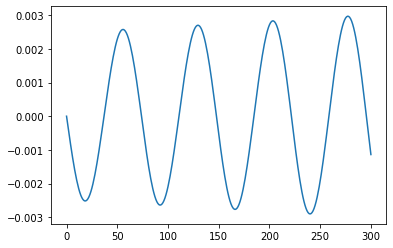

In [29]:
import matplotlib.pyplot as plt 

#plt.plot(x_poses)
plt.plot(y_poses)

#plt.plot(actions)

In [73]:
fuzzy_controller = create_controller()

import time 

state = env.reset()
obs = state[0]
total_reward = 0
done = False
episode = 1
k = 0
x_poses = []
y_poses = []
a_speeds = []
actions = []
while not done:
    # theta_value = get_theta(obs[0], obs[1])
    x_poses.append(obs[0])
    y_poses.append(obs[1])
    a_speeds.append(obs[2])
    try:
        fuzzy_controller.input['x_pos'] = obs[0]
        fuzzy_controller.input['y_pos'] = obs[1]
        fuzzy_controller.input['angular_velocity'] = obs[2]
        fuzzy_controller.compute()
        action = fuzzy_controller.output['torque']
    except:
        action = 0
    actions.append(action)
    obs, reward, done, _, _ = env.step([action])
    total_reward += reward
    k += 1

    time.sleep(0.1)

    if k > 300:
        break

print(total_reward)
env.close()

-1941.980745417191
